In [1]:
import numpy as np
from scipy.stats import kstat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axisartist.axislines import AxesZero

from lamom.proportions import kMoment

# Point Estimate

In [2]:
# load admixture proportions for each chromosomes, estimated by ADMIXTURE
prop = np.zeros((22, 259, 2))
bias = np.zeros((22, 259, 2))
sigma = np.zeros((22, 259, 2))
for i in range(1, 23):
    prop[i-1] = np.loadtxt(f'ADMIXTURE_results/completeDataSetChr{i}.2.Q')
    bias[i-1] = np.loadtxt(f'ADMIXTURE_results/completeDataSetChr{i}.2.Q_bias')
    sigma[i-1] = np.loadtxt(f'ADMIXTURE_results/completeDataSetChr{i}.2.Q_se')

In [3]:
# lengths of 22 chromosomes in Morgans units.
lengths = np.array([2.86279234, 2.68839622, 2.23361095, 2.14667992118, 2.04089357, 
                    1.920175851864947, 1.872205, 1.68003442, 1.66359329, 1.81144, 
                    1.5821865, 1.74679023, 1.25706316, 1.20202583, 1.41730338572, 
                    1.34037726, 1.28490529, 1.17708923, 1.07733846, 1.08266934, 
                    0.62786478, 0.74109562])

# sampling k-statistics from admixture proportions
# k-statistics for YRI population is used for estimating parameters,
# since it is supposed to be a popualtion that admixed once

pop = 1 # 1 - YRI, 0 - CEU
sample_k1 = np.zeros(22)
sample_k2 = np.zeros(22)
sample_k3 = np.zeros(22)
for i in range(22):
    k1 = np.array(kstat((prop)[i, 102:144, pop], 1))
    k2 = kstat((prop)[i, 102:144, pop], 2)
    k3 = np.array(kstat((prop)[i, 102:144, pop], 3))
    
    # correction of k-statistics as it is described in the paper
    k2_corrected = k2 - (sigma[i, 102:144, pop]**2).mean()
    k3_corrected = k3 - 3*np.cov(prop[i, 102:144, pop], sigma[i, 102:144, pop]**2)[0, 1]
    
    # correction for genotype data
    sample_k1[i] = k1
    sample_k2[i] = k2_corrected * 2
    sample_k3[i] = k3_corrected * 4

In [4]:
# initialization of a kMoment object,
# N=10000 is an approximate effective population size
exp = kMoment(N=10000)
exp.sample(sample_k1, sample_k2, sample_k3, lengths)

Your k-statistics (sorted by length):
Length (M.)	k_1	k_2	k_3
0.63	0.76177550	0.06594074	-0.00983211
0.74	0.76799950	0.09070918	-0.02760331
1.08	0.81249524	0.02969751	-0.00102434
1.08	0.83052550	0.04318646	-0.01522780
1.18	0.81249333	0.06872769	-0.02287109
1.20	0.81466279	0.03809531	-0.00332121
1.26	0.82159993	0.03269616	-0.01076115
1.28	0.80581510	0.04249597	-0.00153612
1.34	0.80774971	0.07582421	-0.03802327
1.42	0.82105490	0.03794561	-0.01259985
1.58	0.80023936	0.03398061	-0.00755176
1.66	0.78448090	0.02558254	-0.00101643
1.68	0.81478888	0.05544862	-0.01437733
1.75	0.79144957	0.03717193	-0.00320289
1.81	0.79592895	0.03294647	-0.00814888
1.87	0.82656586	0.02335821	-0.00267451
1.92	0.79943262	0.04278178	-0.00805097
2.04	0.81875269	0.03998856	-0.00073649
2.15	0.81985817	0.03630655	-0.00581033
2.23	0.79517721	0.04644326	-0.01062344
2.69	0.79674369	0.03932009	-0.00524622
2.86	0.78754343	0.03938118	-0.00599687


In [5]:
# esimating of parameters with initial guess T_e = 5, T_d = 5.
# Warning with complex numbers would be fixed.
# It appears because of a numercal eigendecomposition of a matrix $LUD$.
x = exp.estimate(x0=[5, 5])

5.0 5.0


/Users/mikhailshishkin/opt/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:523: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


5.000000074505806 5.0
5.0 5.000000074505806
3.363814005571836 3.3957342550479996
3.3638140556965705 3.3957342550479996
3.363814005571836 3.395734305648383
3.245635060281771 3.4653695557696964
3.2456351086455024 3.4653695557696964
3.245635060281771 3.4653696074077267
1.633873291355242 6.506769625948435
2.841138202360215 4.225464911457864
2.8411382446964737 4.225464911457864
2.841138202360215 4.225464974422199
2.1798405726904386 5.6660591317778675
2.1798406051725943 5.6660591317778675
2.1798405726904386 5.666059216208728
1.6385726193026802 7.136663706210351
1.6385726437193149 7.136663706210351
1.6385726193026802 7.136663812554928
1.7492502286656169 6.927474125057232
1.7492502547314766 6.927474125057232
1.7492502286656169 6.927474228284641
1.7525310912170813 6.921882141278096
1.7525311173318296 6.921882141278096
1.7525310912170813 6.921882244422178
1.752557462086923 6.921833164385515
1.7525574882020643 6.921833164385515
1.752557462086923 6.921833267528867


In [8]:
s = exp.model.get_prop_per_gen(x.x[1])
estimate_k2 = exp.model.get_k2(s, x.x[0], x.x[1])
estimate_k3 = exp.model.get_k3(s, x.x[0], x.x[1])

In [9]:
T_e_pe = x.x[0]
T_d_pe = x.x[1]
T_s_pe = T_d_pe + T_e_pe - 1
print(f'Point estimate: s={s}, T={x.x[0]}, T_d={x.x[1]}')
print(*estimate_k2)
print(*estimate_k3)
print(x)

Point estimate: s=0.031032462560122154, T=1.752557462086923, T_d=6.921833164385515
0.0720095257951068 0.06577829426957764 0.052633698024749306 0.05247114569143432 0.04976681984521387 0.049103732506342264 0.047708254525672796 0.047035789178243165 0.045757924029777484 0.04411077628540818 0.040998689739843656 0.03964075985093054 0.03937908895567872 0.038356837299801265 0.03742435704425055 0.036595276488404285 0.03597082919825732 0.03450607820629167 0.03333482571792687 0.03244175707951574 0.028580759643421653 0.02738358646405919
-0.027117959476979807 -0.02322477991013589 -0.015766877192791188 -0.01568161334890891 -0.014289816134608791 -0.013956363360301552 -0.013264860275139546 -0.012936654872234473 -0.012322107793210585 -0.011547895904394779 -0.010141700434994584 -0.009551936785462997 -0.00943998789234332 -0.009007963769833429 -0.00862133830026792 -0.008283635451533905 -0.00803308482407299 -0.00745835549409067 -0.007012076087423323 -0.0066798535743556355 -0.005325979894401455 -0.004934108

# Confidence Intervals

In [10]:
# Simulation of admixture proportion with error.

seed = 1720019256
rng = np.random.default_rng(seed=seed)
n = 100

simulated_prop = np.zeros((n, 22, 42))
simulated_sample = np.zeros((n, 3, 22))

for sim_i in range(n):
    for chr_i in range(22):
        for sample_i in range(42):
            simulated_prop[sim_i, chr_i, sample_i] = rng.normal(prop[chr_i, 102+sample_i, pop], sigma[chr_i, 102 + sample_i, pop])
        
        k1 = kstat(simulated_prop[sim_i, chr_i], 1)
        k2 = kstat(simulated_prop[sim_i, chr_i], 2)
        k3 = kstat(simulated_prop[sim_i, chr_i], 3) 
        
        k2_corrected = k2 - 2*(sigma[chr_i, 102:144, pop]**2).mean()
        k3_corrected = k3 - 2*3*np.cov(prop[chr_i, 102:144, pop], sigma[chr_i, 102:144, pop]**2)[0, 1]
        
        simulated_sample[sim_i, 0, chr_i] = k1 
        simulated_sample[sim_i, 1, chr_i] = k2_corrected * 2
        simulated_sample[sim_i, 2, chr_i] = k3_corrected * 4
    np.savetxt(f'simulation_sample/simulated_sample_{sim_i}.txt', simulated_sample[sim_i])

In [11]:
# Then method was performed separately for each generated sample. 
# It was launched with script estimate_CI.py and all 
# output is presented in the APPLICATIONS/simulation_result directory.

In [13]:
# load estimated parameters and k-statistics expectations.
conf_res = np.zeros((n, 4))
conf_k2 = np.zeros((n, 22))
conf_k3 = np.zeros((n, 22))
filename = 'simulation_results/conf_final.txt'
with open(filename,"r") as f:
    c = 0
    i = 0
    for line in f:
        temp_data = np.array(list(map(float, line.split())))
        if c % 3 == 0:
            conf_res[i] = temp_data
        if c % 3 == 1:
            conf_k2[i] = temp_data
        if c % 3 == 2:
            conf_k3[i] = temp_data 
            i += 1
        c += 1
        
conf_T_e = conf_res[:, 1]
conf_T_s = conf_res[:, 2] + conf_res[:, 1] - 1

# Construction of the confidence interval 
# by removing of 2 first and 2 last estiamtes
# in sorted arrays
conf_T_e_95 = np.sort(conf_T_e)[2:-2][[0, -1]]
conf_T_s_95 = np.sort(conf_T_s)[2:-2][[0, -1]]

# Visualisation

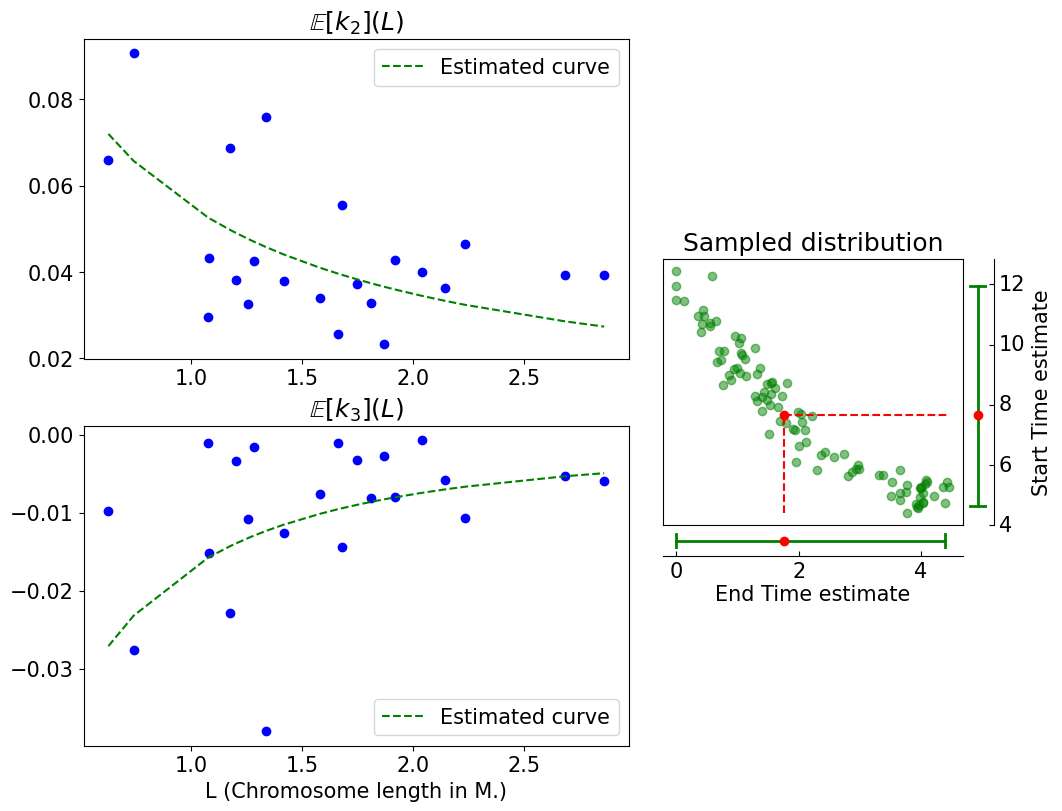

In [14]:
plt.rcParams['font.size'] = 15


def plot_reg_line(ax, x, data, estimate):
    ax.plot(x, data, 'bo')
    ax.plot(x, estimate, 'g--', label='Estimated curve')
        
l = exp.model.get_sample()[1]
sample_k2 = exp.model.get_sample()[0][:22]
sample_k3 = exp.model.get_sample()[0][22:]

fig = plt.figure(layout="constrained", figsize=(9, 8))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[1, :2])
ax_points = fig.add_axes([0.73, 0.35, 1/3, 1/3]) 
ax_points.set_xticks([])
ax_points.set_yticks([])

ax_right = fig.add_axes([1.07, 0.35, 0.02, 1/3], axes_class=AxesZero) 
ax_right.axis["right"].set_visible(False)
ax_right.axis["top"].set_visible(False)
ax_right.axis["left"].set_visible(False)
ax_right.axis["bottom"].set_visible(False)
ax_right.axis["xzero"] = ax_right.new_fixed_axis(loc="right", offset=(5, 0))
ax_right.axis["xzero"].label.set_text("Start Time estimate")

ax_bottom = fig.add_axes([0.73, 0.32, 1/3, 0.02], axes_class=AxesZero) 
ax_bottom.axis["right"].set_visible(False)
ax_bottom.axis["top"].set_visible(False)
ax_bottom.axis["left"].set_visible(False)
ax_bottom.axis["bottom"].set_visible(False)
ax_bottom.axis["yzero"] = ax_bottom.new_fixed_axis(loc="bottom", offset=(0, -5))
ax_bottom.axis["yzero"].label.set_text("End Time estimate")

plot_reg_line(ax1, l, sample_k2, estimate_k2)
plot_reg_line(ax2, l, sample_k3, estimate_k3)

ax1.set_title('$\mathbb{E}[k_2](L)$')
ax2.set_title('$\mathbb{E}[k_3](L)$')
ax2.set_xlabel('L (Chromosome length in M.)')
ax_points.set_title('Sampled distribution')

w = 0.1
rat = 2

ax_points.plot(conf_T_e, conf_T_s, 'go', alpha=0.5)
ax_points.plot([T_e_pe]*2, [min(conf_T_s), T_s_pe], 'r--')
ax_points.plot([T_e_pe, max(conf_T_e)], [T_s_pe]*2, 'r--')
ax_points.plot(T_e_pe, T_s_pe, 'ro')

ax_right.plot(rat*w, max(conf_T_s))
ax_right.plot(rat*w, min(conf_T_s))
ax_right.plot([rat*w, rat*w], conf_T_s_95, 'green', linewidth=2)
ax_right.plot([-w+rat*w, w+rat*w], [conf_T_s_95[0]]*2, 'green', linewidth=2)
ax_right.plot([-w+rat*w, w+rat*w], [conf_T_s_95[1]]*2, 'green', linewidth=2)
ax_right.plot(rat*w, T_s_pe, 'ro')
ax_right.set_yticks([4, 6, 8, 10, 12])
# ax_points.set_yticks([4, 6, 8, 12])


ax_bottom.plot(max(conf_T_e), rat*w)
ax_bottom.plot(min(conf_T_e), rat*w)
ax_bottom.plot(conf_T_e_95, [rat*w, rat*w], 'green', linewidth=2)
ax_bottom.plot([conf_T_e_95[0]]*2, [-w+rat*w, w+rat*w], 'green', linewidth=2)
ax_bottom.plot([conf_T_e_95[1]]*2, [-w+rat*w, w+rat*w], 'green', linewidth=2)
ax_bottom.plot(T_e_pe, rat*w, 'ro')

ax1.legend()
ax2.legend()